# Sizing for Basic 5T-OTA With Schematic

**Copyright 2024-2025 Harald Pretl**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

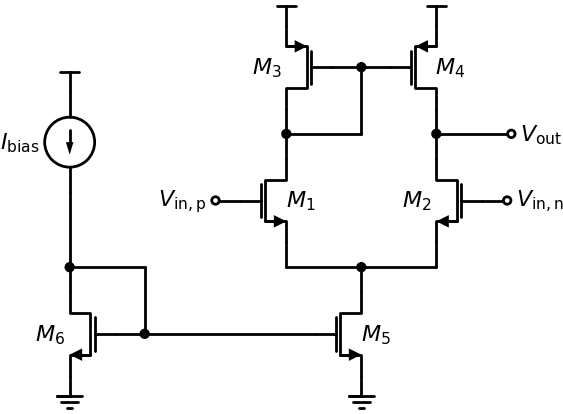

In [1]:
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    M1 = elm.AnalogNFet(offset_gate=False).drop('source').theta(0).label('$M_1$', ofst=-1.5).reverse()
    elm.Line().down().length(0.5)
    elm.Line().right().length(1.5).dot()
    d.push()

    elm.Line().down().length(0.5)
    M5 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label('$M_5$', ofst=-1.5).reverse()
    elm.Ground()
    elm.Line().left().length(4).at(M5.gate)
    M6 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label('$M_6$')
    elm.Ground()
    elm.Line().up().dot().at(M6.drain).length(0.5)
    d.push()
    elm.Line().up().length(1.5)
    Ibias = elm.SourceI().up().label(r'$I_\mathrm{bias}$').reverse()
    elm.Vdd()
    d.pop()
    elm.Line().right().length(1.5)
    elm.Line().down().toy(M6.gate).dot()

    d.pop()
    elm.Line().right().length(1.5)
    elm.Line().up().length(0.5)
    M2 = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label('$M_2$')
    
    elm.Line().left().at(M1.gate).length(0.5).dot(open=True).label(r'$V_\mathrm{in,p}$', 'left')
    elm.Line().right().at(M2.gate).length(0.5).dot(open=True).label(r'$V_\mathrm{in,n}$', 'right')
    
    elm.Line().up().at(M1.drain).length(0.5).dot()
    d.push()
    elm.Line().up().length(0.5)
    M3 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label('$M_3$')
    elm.Vdd().at(M3.source)

    elm.Line().up().at(M2.drain).length(0.5).dot()
    d.push()
    elm.Line().right().length(1.5).dot(open=True).label(r'$V_\mathrm{out}$', 'right')
    d.pop()
    elm.Line().up().length(0.5)
    M4 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label('$M_4$', ofst=-1.5).reverse()
    elm.Vdd().at(M4.source)

    elm.Line().at(M4.gate).tox(M3.gate)
    
    d.pop()
    elm.Line().right().tox(M5.drain)
    elm.Line().up().toy(M3.gate).dot()

In [2]:
# read table data
from pygmid import Lookup as lk
import numpy as np
lv_nmos = lk('sg13_lv_nmos.mat')
lv_pmos = lk('sg13_lv_pmos.mat')
# list of parameters: VGS, VDS, VSB, L, W, NFING, ID, VT, GM, GMB, GDS, CGG, CGB, CGD, CGS, CDD, CSS, STH, SFL
# if not specified, minimum L, VDS=max(vgs)/2=0.9 and VSB=0 are used 

In [3]:
# define the given parameters as taken from the specification table or initial guesses
c_load = 50e-15
gm_id_m12 = 10
gm_id_m34 = 5
gm_id_m56 = 5
l_12 = 5
l_34 = 5
l_56 = 5
f_bw = 10e6 # -3dB bandwidth of the voltage buffer
i_total_limit = 10e-6
i_bias_in = 20e-6
output_voltage = 1.3
vin_min = 0.7
vin_max = 0.9
vdd_min = 1.45
vdd_max = 1.55

In [4]:
# we get the required gm of M1/2 from the -3dB bandwidth requirement of the voltage buffer specification
# note that the -3dB bandwidth of the voltage buffer with gain Av=1 is equal to the unity gain bandwidth
# of the ota, hence we wet them equal here
# we add a factor of 3 to allow for PVT variation plus additional MOSFET parasitic loading
gm_m12 = f_bw * 3 * 4*np.pi*c_load
print('gm12 =', round(gm_m12/1e-3, 4), 'mS')

gm12 = 0.0188 mS


In [5]:
# since we know gm12 and the gmid we can calculate the bias current
id_m12 = gm_m12 / gm_id_m12
i_total = 2*id_m12
print('i_total (exact) =', round(i_total/1e-6, 1), 'µA')
# we round to 0.5µA bias currents
i_total = max(round(i_total / 1e-6 * 2) / 2 * 1e-6, 0.5e-6)
id_m12 = i_total/2

print('i_total (rounded) =', i_total/1e-6, 'µA')
if i_total < i_total_limit:
    print('[info] power consumption target is met!')
else:
    print('[info] power consumption target is NOT met!') 

i_total (exact) = 3.8 µA
i_total (rounded) = 4.0 µA
[info] power consumption target is met!


In [6]:
# we calculate the dc gain
gm_gds_m12 = lv_nmos.lookup('GM_GDS', GM_ID=gm_id_m12, L=l_12, VDS=0.75, VSB=0)
gm_gds_m34 = lv_pmos.lookup('GM_GDS', GM_ID=gm_id_m34, L=l_34, VDS=0.75, VSB=0)

gds_m12 = gm_m12 / gm_gds_m12
gm_m34 = gm_id_m34 * i_total/2
gds_m34 = gm_m34 / gm_gds_m34

a0 = gm_m12 / (gds_m12 + gds_m34)
print('a0 =', round(20*np.log10(a0), 1), 'dB')

a0 = 34.8 dB


In [7]:
# we calculate the MOSFET capacitance which adds to Cload, to see the impact on the BW
gm_cgs_m12 = lv_nmos.lookup('GM_CGS', GM_ID=gm_id_m12, L=l_12, VDS=0.75, VSB=0)
gm_cdd_m12 = lv_nmos.lookup('GM_CDD', GM_ID=gm_id_m12, L=l_12, VDS=0.75, VSB=0)
gm_cdd_m34 = lv_pmos.lookup('GM_CDD', GM_ID=gm_id_m34, L=l_34, VDS=0.75, VSB=0)

c_load_parasitic = abs(gm_m12/gm_cgs_m12) + abs(gm_m12/gm_cdd_m12) + abs(gm_m34/gm_cdd_m34)
print('additional load capacitance =', round(c_load_parasitic/1e-15, 1), 'fF')

f_bw = gm_m12 / (4*np.pi * (c_load + c_load_parasitic))
print('unity gain bandwidth incl. parasitics =', round(f_bw/1e6, 2), 'MHz')

additional load capacitance = 54.9 fF
unity gain bandwidth incl. parasitics = 14.3 MHz


In [8]:
# we can now look up the VGS of the MOSFET
vgs_m12 = lv_nmos.look_upVGS(GM_ID=gm_id_m12, L=l_12, VDS=0.75, VSB=0.0)
vgs_m34 = lv_pmos.look_upVGS(GM_ID=gm_id_m34, L=l_34, VDS=0.75, VSB=0.0) 
vgs_m56 = lv_nmos.look_upVGS(GM_ID=gm_id_m56, L=l_56, VDS=0.75, VSB=0.0) 

print('vgs_12 =', round(float(vgs_m12), 3), 'V')
print('vgs_34 =', round(float(vgs_m34), 3), 'V')
print('vgs_56 =', round(float(vgs_m56), 3), 'V')

vgs_12 = 0.367 V
vgs_34 = 0.729 V
vgs_56 = 0.591 V


In [9]:
# calculate settling time due to slewing with the calculated bias current
t_slew = (c_load + c_load_parasitic) * output_voltage / i_total
print('slewing time =', round(t_slew/1e-6, 3), 'µs')
t_settle = 5/(2*np.pi*f_bw)
print('settling time =', round(t_settle/1e-6, 3), 'µs')

slewing time = 0.034 µs
settling time = 0.056 µs


In [10]:
# calculate voltage gain error
gain_error = a0 / (1 + a0)
print('voltage gain error =', round((gain_error-1)*100, 1), '%')

voltage gain error = -1.8 %


In [11]:
# calculate total rms output noise
sth_m12 = lv_nmos.lookup('STH_GM', VGS=vgs_m12, L=l_12, VDS=0.75, VSB=0) * gm_m12
gamma_m12 = sth_m12/(4*1.38e-23*300*gm_m12)

sth_m34 = lv_pmos.lookup('STH_GM', VGS=vgs_m34, L=l_34, VDS=0.75, VSB=0) * gm_m34
gamma_m34 = sth_m34/(4*1.38e-23*300*gm_m34)

output_noise_rms = np.sqrt(1.38e-23*300 / (c_load + c_load_parasitic) * (2*gamma_m12 + 2*gamma_m34 * gm_m34/gm_m12))
print('output noise =', round(output_noise_rms/1e-6, 1), 'µVrms')

output noise = 354.2 µVrms


In [12]:
# calculate all widths
id_w_m12 = lv_nmos.lookup('ID_W', GM_ID=gm_id_m12, L=l_12, VDS=vgs_m12, VSB=0)
w_12 = id_m12 / id_w_m12
w_12_round = max(round(w_12*2)/2, 0.5)
print('M1/2 W =', round(w_12, 2), 'um, rounded W =', w_12_round, 'um')

id_m34 = id_m12
id_w_m34 = lv_pmos.lookup('ID_W', GM_ID=gm_id_m34, L=l_34, VDS=vgs_m34, VSB=0)
w_34 = id_m34 / id_w_m34
w_34_round = max(round(w_34*2)/2, 0.5) 
print('M3/4 W =', round(w_34, 2), 'um, rounded W =', w_34_round, 'um')

id_w_m5 = lv_nmos.lookup('ID_W', GM_ID=gm_id_m56, L=l_56, VDS=vgs_m56, VSB=0)
w_5 = i_total / id_w_m5
w_5_round = max(round(w_5*2)/2, 0.5)
print('M5 W =', round(w_5, 2), 'um, rounded W =', w_5_round, 'um')
w_6 = w_5_round * i_bias_in / i_total
w_6_round = max(round(w_6*2)/2, 0.5)
print('M6 W =', round(w_6_round, 2), 'um')

M1/2 W = 1.77 um, rounded W = 2.0 um
M3/4 W = 1.64 um, rounded W = 1.5 um
M5 W = 0.74 um, rounded W = 0.5 um
M6 W = 2.5 um


In [13]:
# print out final design values
print('5T-OTA dimensioning:')
print('--------------------')
print('M1/2 W=', w_12_round, ', L=', l_12)
print('M3/4 W=', w_34_round, ', L=', l_34)
print('M5   W=', w_5_round, ', L=', l_56)
print('M6   W=', w_6_round, ', L=', l_56)
print()
print('5T-OTA performance summary:')
print('---------------------------')
print('supply current =', round(i_total/1e-6, 1), 'µA')
print('output noise =', round(output_noise_rms/1e-6, 1), 'µVrms')
print('voltage gain error =', round((gain_error-1)*100, 1), '%')
print('unity gain bandwidth incl. parasitics =', round(f_bw/1e6, 2), 'MHz')
print('turn-on time (slewing+settling) =', round((t_slew+t_settle)/1e-6, 3), 'µs')
print()
print('5T-OTA bias point check:')
print('------------------------')
print('headroom M1 =', round(vdd_min-vgs_m34+vgs_m12-vin_max, 3), 'V')
print('headroom M4 =', round(vdd_min-vin_max, 3), 'V')
print('headroom M5 =', round(vin_min-vgs_m12, 3), 'V')

5T-OTA dimensioning:
--------------------
M1/2 W= 2.0 , L= 5
M3/4 W= 1.5 , L= 5
M5   W= 0.5 , L= 5
M6   W= 2.5 , L= 5

5T-OTA performance summary:
---------------------------
supply current = 4.0 µA
output noise = 354.2 µVrms
voltage gain error = -1.8 %
unity gain bandwidth incl. parasitics = 14.3 MHz
turn-on time (slewing+settling) = 0.09 µs

5T-OTA bias point check:
------------------------
headroom M1 = 0.188 V
headroom M4 = 0.55 V
headroom M5 = 0.333 V


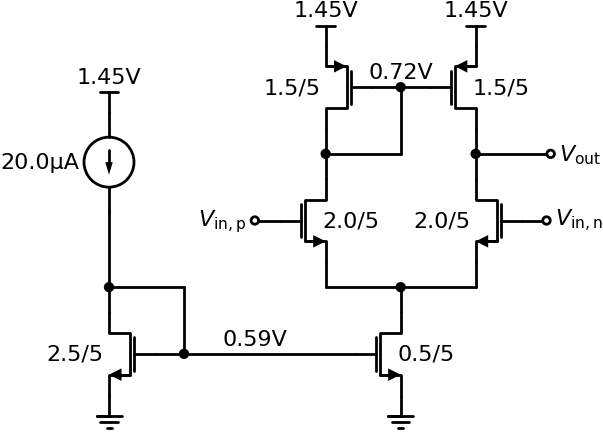

In [14]:
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    M1 = elm.AnalogNFet(offset_gate=False).drop('source').theta(0).label(str(w_12_round)+'/'+str(l_12), ofst=-2).reverse()
    elm.Line().down().length(0.5)
    elm.Line().right().length(1.5).dot()
    d.push()

    elm.Line().down().length(0.5)
    M5 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(str(w_5_round)+'/'+str(l_56), ofst=-2).reverse()
    elm.Ground()
    elm.Line().left().length(4).at(M5.gate).label(str(round(float(vgs_m56),2))+'V')
    M6 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(str(w_6_round)+'/'+str(l_56))
    elm.Ground()
    elm.Line().up().dot().at(M6.drain).length(0.5)
    d.push()
    elm.Line().up().length(1.5)
    Ibias = elm.SourceI().up().label(str(round(i_bias_in/1e-6,0))+'µA').reverse()
    elm.Vdd().label(str(vdd_min)+'V')
    d.pop()
    elm.Line().right().length(1.5)
    elm.Line().down().toy(M6.gate).dot()

    d.pop()
    elm.Line().right().length(1.5)
    elm.Line().up().length(0.5)
    M2 = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(str(w_12_round)+'/'+str(l_12))
    
    elm.Line().left().at(M1.gate).length(0.5).dot(open=True).label(r'$V_\mathrm{in,p}$', 'left')
    elm.Line().right().at(M2.gate).length(0.5).dot(open=True).label(r'$V_\mathrm{in,n}$', 'right')
    
    elm.Line().up().at(M1.drain).length(0.5).dot()
    d.push()
    elm.Line().up().length(0.5)
    M3 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(str(w_34_round)+'/'+str(l_34))
    elm.Vdd().at(M3.source).label(str(vdd_min)+'V')

    elm.Line().up().at(M2.drain).length(0.5).dot()
    d.push()
    elm.Line().right().length(1.5).dot(open=True).label(r'$V_\mathrm{out}$', 'right')
    d.pop()
    elm.Line().up().length(0.5)
    M4 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(str(w_34_round)+'/'+str(l_34), ofst=-2).reverse()
    elm.Vdd().at(M4.source).label(str(vdd_min)+'V')

    elm.Line().at(M4.gate).tox(M3.gate).label(str(round(vdd_min-vgs_m34,2))+'V')
    
    d.pop()
    elm.Line().right().tox(M5.drain)
    elm.Line().up().toy(M3.gate).dot()